#Pseudocode: Policy Evaluation

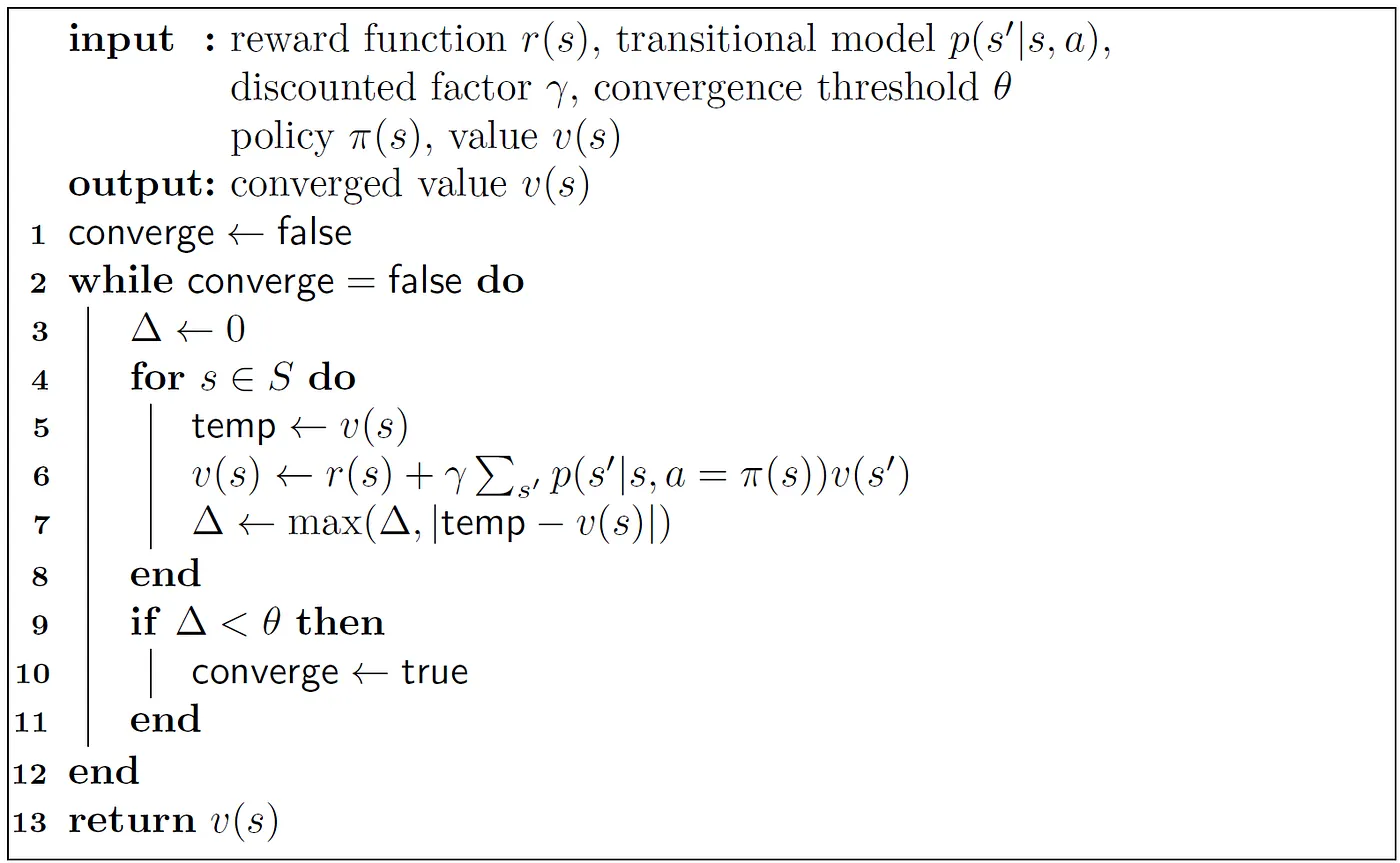

#Pseudocode for Policy Improvement

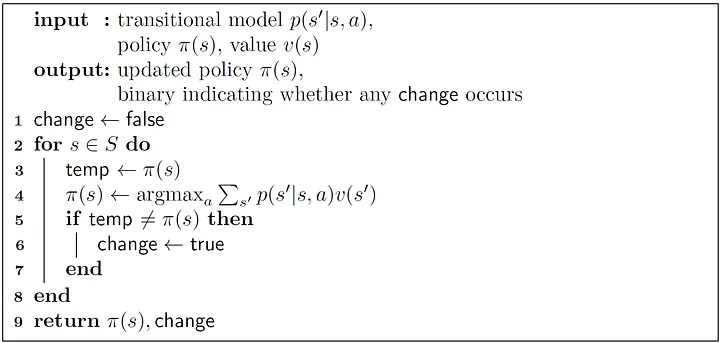

#Pseudocode for Policy Iteration

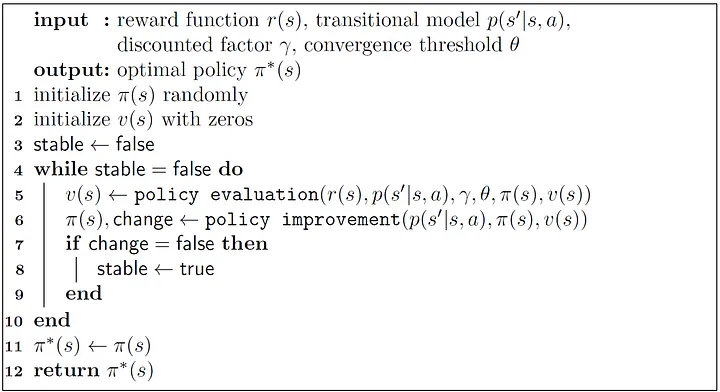

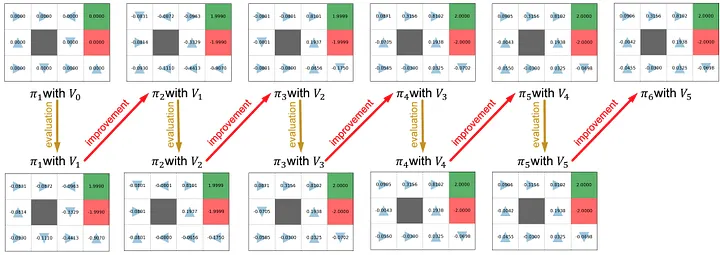

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class PolicyIteration:
    def __init__(self, reward_function, transition_model, gamma, init_policy=None):
        self.num_states = transition_model.shape[0]
        self.num_actions = transition_model.shape[1]
        self.reward_function = np.nan_to_num(reward_function)

        self.transition_model = transition_model
        self.gamma = gamma

        self.values = np.zeros(self.num_states)
        if init_policy is None:
            self.policy = np.random.randint(0, self.num_actions, self.num_states)
        else:
            self.policy = init_policy

    def one_policy_evaluation(self):
        delta = 0
        for s in range(self.num_states):
            temp = self.values[s]
            a = self.policy[s]
            p = self.transition_model[s, a]
            self.values[s] = self.reward_function[s] + self.gamma * np.sum(p * self.values)
            delta = max(delta, abs(temp - self.values[s]))
        return delta

    def run_policy_evaluation(self, tol=1e-3):
        epoch = 0
        delta = self.one_policy_evaluation()
        delta_history = [delta]
        while epoch < 500:
            delta = self.one_policy_evaluation()
            delta_history.append(delta)
            if delta < tol:
                break
        return len(delta_history)

    def run_policy_improvement(self):
        update_policy_count = 0
        for s in range(self.num_states):
            temp = self.policy[s]
            v_list = np.zeros(self.num_actions)
            for a in range(self.num_actions):
                p = self.transition_model[s, a]
                v_list[a] = np.sum(p * self.values)
            self.policy[s] = np.argmax(v_list)
            if temp != self.policy[s]:
                update_policy_count += 1
        return update_policy_count

    def train(self, tol=1e-3, plot=True):
        epoch = 0
        eval_count = self.run_policy_evaluation(tol=tol)
        eval_count_history = [eval_count]
        policy_change = self.run_policy_improvement()
        policy_change_history = [policy_change]
        while epoch < 500:
            epoch += 1
            new_eval_count = self.run_policy_evaluation(tol)
            new_policy_change = self.run_policy_improvement()
            eval_count_history.append(new_eval_count)
            policy_change_history.append(new_policy_change)
            if new_policy_change == 0:
                break

        print(f'# epoch: {len(policy_change_history)}')
        print(f'eval count = {eval_count_history}')
        print(f'policy change = {policy_change_history}')

        if plot is True:
            fig, axes = plt.subplots(2, 1, figsize=(3.5, 4), sharex='all', dpi=200)
            axes[0].plot(np.arange(len(eval_count_history)), eval_count_history, marker='o', markersize=4, alpha=0.7,
                         color='#2ca02c', label='# sweep in \npolicy evaluation\n' + r'$\gamma =$' + f'{self.gamma}')
            axes[0].legend()

            axes[1].plot(np.arange(len(policy_change_history)), policy_change_history, marker='o',
                         markersize=4, alpha=0.7, color='#d62728',
                         label='# policy updates in \npolicy improvement\n' + r'$\gamma =$' + f'{self.gamma}')
            axes[1].set_xlabel('Epoch')
            axes[1].legend()
            plt.tight_layout()
            plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from time import time


class GridWorld:
    def __init__(self, filename, reward, random_rate, time_limit=1000):
        file = open(filename)
        self.map = np.array(
            [list(map(float, s.strip().split(","))) for s in file.readlines()]
        )
        file.close()
        self.num_rows = self.map.shape[0]
        self.num_cols = self.map.shape[1]
        self.num_states = self.num_rows * self.num_cols
        self.num_actions = 4
        self.reward = reward
        self.random_rate = random_rate
        self.time_limit = time_limit
        self.reward_function = self.get_reward_function()
        self.transition_model = self.get_transition_model()

    def get_state_from_pos(self, pos):
        return pos[0] * self.num_cols + pos[1]

    def get_pos_from_state(self, state):
        return state // self.num_cols, state % self.num_cols

    def get_reward_function(self):
        reward_table = np.zeros(self.num_states)
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                s = self.get_state_from_pos((r, c))
                reward_table[s] = self.reward[self.map[r, c]]
        return reward_table

    def get_transition_model(self):
        transition_model = np.zeros((self.num_states, self.num_actions, self.num_states))
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                s = self.get_state_from_pos((r, c))
                neighbor_s = np.zeros(self.num_actions)
                if self.map[r, c] == 0:
                    for a in range(self.num_actions):
                        new_r, new_c = r, c
                        if a == 0:
                            new_r = max(r - 1, 0)
                        elif a == 1:
                            new_c = min(c + 1, self.num_cols - 1)
                        elif a == 2:
                            new_r = min(r + 1, self.num_rows - 1)
                        elif a == 3:
                            new_c = max(c - 1, 0)
                        if self.map[new_r, new_c] == 3:
                            new_r, new_c = r, c
                        s_prime = self.get_state_from_pos((new_r, new_c))
                        neighbor_s[a] = s_prime
                else:
                    neighbor_s = np.ones(self.num_actions) * s
                for a in range(self.num_actions):
                    transition_model[s, a, int(neighbor_s[a])] += 1 - self.random_rate
                    transition_model[s, a, int(neighbor_s[(a + 1) % self.num_actions])] += self.random_rate / 2.0
                    transition_model[s, a, int(neighbor_s[(a - 1) % self.num_actions])] += self.random_rate / 2.0
        return transition_model

    def generate_random_policy(self):
        return np.random.randint(self.num_actions, size=self.num_states)

    def execute_policy(self, policy, start_pos):
        s = self.get_state_from_pos(start_pos)
        r = self.reward_function[s]
        total_reward = r

        start_time = int(round(time() * 1000))
        overtime = False

        while r != self.reward[1] and r != self.reward[2]:
            s = np.random.choice(self.num_states, p=self.transition_model[s, policy[s]])
            r = self.reward_function[s]
            total_reward += r
            cur_time = int(round(time() * 1000)) - start_time
            if cur_time > self.time_limit:
                overtime = True
                break
        if overtime is True:
            return float('-inf')
        else:
            return total_reward

    def random_start_policy(self, policy, start_pos, n=100, plot=True):
        start_time = int(round(time() * 1000))
        overtime = False
        scores = np.zeros(n)
        i = 0
        while i < n:
            temp = self.execute_policy(policy=policy, start_pos=start_pos)
            print(f'i = {i} Random start result: {temp}')
            if temp > float('-inf'):
                scores[i] = temp
                i += 1
            cur_time = int(round(time() * 1000)) - start_time
            if cur_time > n * self.time_limit:
                overtime = True
                break

        print(f'max = {np.max(scores)}')
        print(f'min = {np.min(scores)}')
        print(f'mean = {np.mean(scores)}')
        print(f'std = {np.std(scores)}')

        if overtime is False and plot is True:
            bins = 100
            fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
            ax.set_xlabel('Total rewards in a single game')
            ax.set_ylabel('Frequency')
            ax.hist(scores, bins=bins, color='#1f77b4', edgecolor='black')
            plt.show()

        if overtime is True:
            print('Overtime!')
            return None
        else:
            return np.max(scores), np.min(scores), np.mean(scores)

    def blackbox_move(self, s, a):
        temp = self.transition_model[s, a]
        s_prime = np.random.choice(self.num_states, p=temp)
        r = self.reward_function[s_prime]
        return s_prime, r

    def plot_map(self, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.num_rows, fig_size[0] // self.num_cols)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')
        for i in range(self.num_cols + 1):
            if i == 0 or i == self.num_cols:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.num_rows + 1):
            if i == 0 or i == self.num_rows:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                y = (self.num_rows - 1 - i) * unit
                x = j * unit
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)

        plt.tight_layout()
        plt.show()

    def plot_policy(self, policy, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.num_rows, fig_size[0] // self.num_cols)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')
        for i in range(self.num_cols + 1):
            if i == 0 or i == self.num_cols:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.num_rows + 1):
            if i == 0 or i == self.num_rows:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                y = (self.num_rows - 1 - i) * unit
                x = j * unit
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)
                s = self.get_state_from_pos((i, j))
                if self.map[i, j] == 0:
                    a = policy[s]
                    symbol = ['^', '>', 'v', '<']
                    ax.plot([x + 0.5 * unit], [y + 0.5 * unit], marker=symbol[a],
                            linestyle='none', markersize=max(fig_size)*unit, color='#1f77b4')

        plt.tight_layout()
        plt.show()

    def visualize_value_policy(self, policy, values, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.num_rows, fig_size[0] // self.num_cols)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')

        for i in range(self.num_cols + 1):
            if i == 0 or i == self.num_cols:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.num_rows + 1):
            if i == 0 or i == self.num_rows:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                y = (self.num_rows - 1 - i) * unit
                x = j * unit
                s = self.get_state_from_pos((i, j))
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)
                if self.map[i, j] != 3:
                    ax.text(x + 0.5 * unit, y + 0.5 * unit, f'{values[s]:.4f}',
                            horizontalalignment='center', verticalalignment='center',
                            fontsize=max(fig_size)*unit*0.6)
                if policy is not None:
                    if self.map[i, j] == 0:
                        a = policy[s]
                        symbol = ['^', '>', 'v', '<']
                        ax.plot([x + 0.5 * unit], [y + 0.5 * unit], marker=symbol[a], alpha=0.4,
                                linestyle='none', markersize=max(fig_size)*unit, color='#1f77b4')

        plt.tight_layout()
        plt.show()





# epoch: 6
eval count = [67, 43, 33, 8, 4, 5]
policy change = [10, 7, 2, 1, 1, 0]


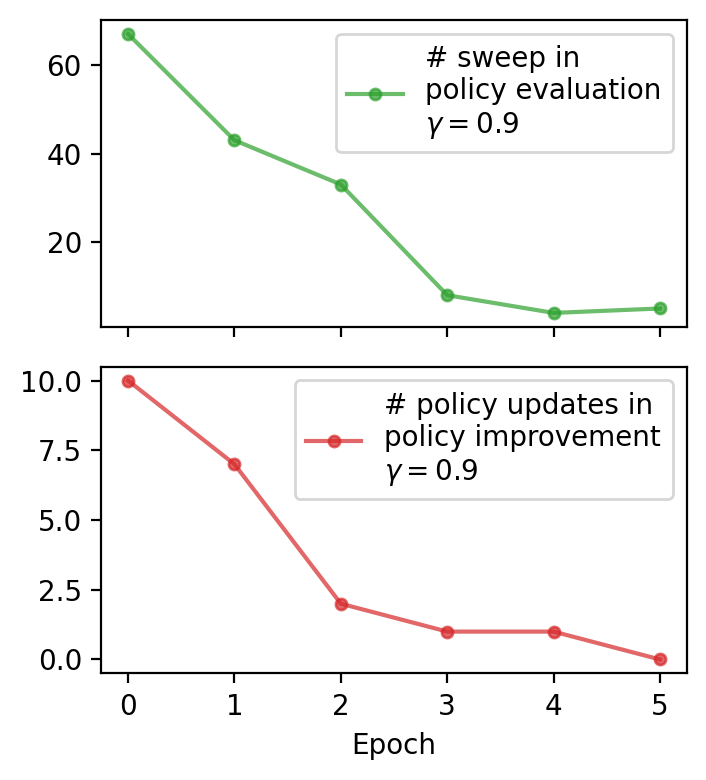

<ipython-input-12-eba000ed2f81>:267: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


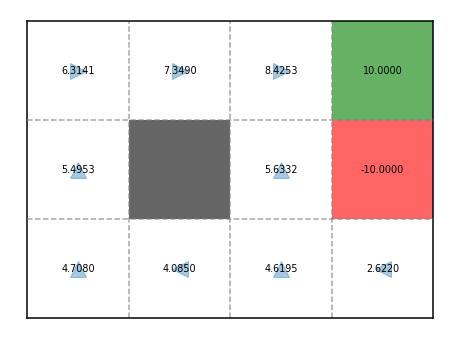

i = 0 Random start result: 0.8
i = 1 Random start result: 0.8
i = 2 Random start result: 0.8
i = 3 Random start result: 0.76
i = 4 Random start result: 0.72
i = 5 Random start result: 0.8
i = 6 Random start result: 0.8
i = 7 Random start result: 0.76
i = 8 Random start result: 0.72
i = 9 Random start result: 0.76
i = 10 Random start result: 0.6000000000000001
i = 11 Random start result: 0.6799999999999999
i = 12 Random start result: 0.8
i = 13 Random start result: 0.72
i = 14 Random start result: 0.8
i = 15 Random start result: 0.76
i = 16 Random start result: 0.8
i = 17 Random start result: 0.8
i = 18 Random start result: 0.8
i = 19 Random start result: 0.6799999999999999
i = 20 Random start result: 0.6799999999999999
i = 21 Random start result: 0.76
i = 22 Random start result: 0.72
i = 23 Random start result: 0.8
i = 24 Random start result: 0.6799999999999999
i = 25 Random start result: 0.6000000000000001
i = 26 Random start result: 0.8
i = 27 Random start result: 0.64
i = 28 Random 

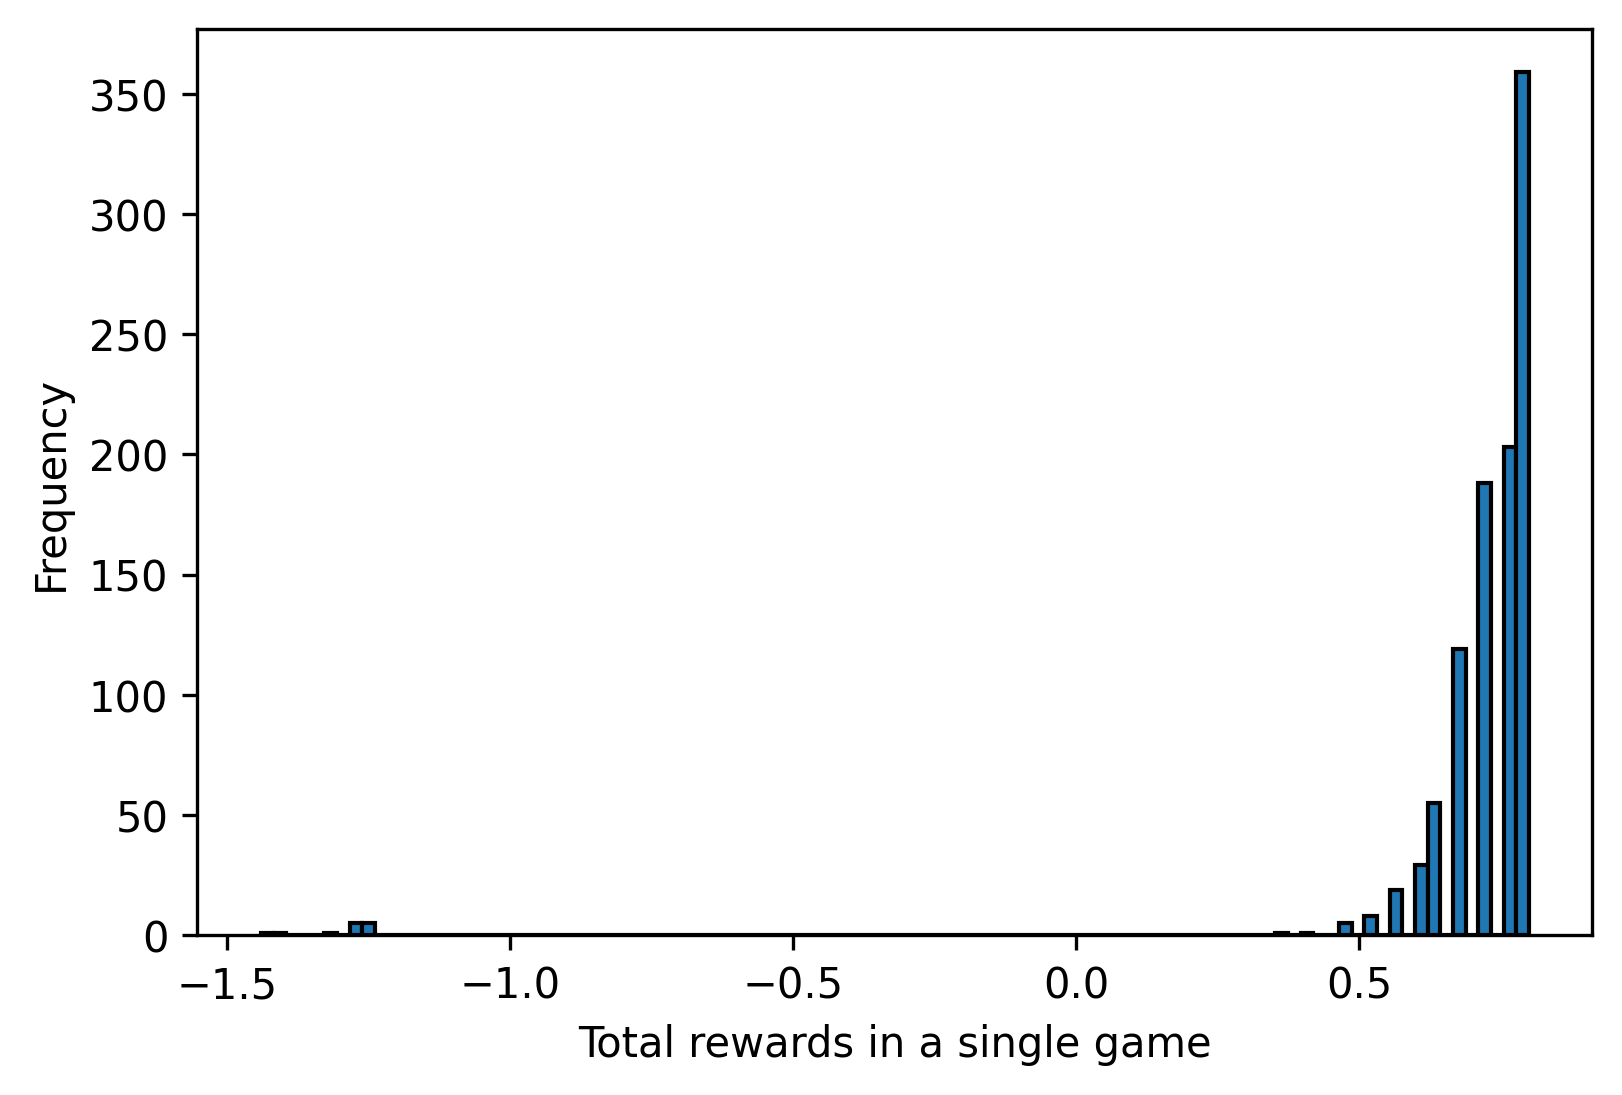

(0.8, -1.44, 0.71156)

In [ ]:
import numpy as np



problem = GridWorld('world00.csv', reward={0: -0.04, 1: 1.0, 2: -1.0, 3: np.NaN}, random_rate=0.2)
policy = [1, 1, 3, 1, 0, 0, 2, 0, 1, 2, 1, 0]

solver = PolicyIteration(problem.reward_function, problem.transition_model, gamma=0.9, init_policy=policy)
solver.train()

problem.visualize_value_policy(policy=solver.policy, values=solver.values)
problem.random_start_policy(policy=solver.policy, start_pos=(2, 0), n=1000)